![title](https://doity.com.br/media/doity/eventos/evento-20025-logo_organizador.png)

# Prova de Descoberta do Conhecimento

* **Prof. Cleilton Lima Rocha**
* **emails:** cleilton_rocha@atlantico.com.br; climarocha@gmail.com
* **deadline: 17/10 às 12h **

Para este projeto exploraremos os dados Call_Data disponível na pasta. Para maiores informações acesse este [link](https://data.seattle.gov/Public-Safety/Call-Data/33kz-ixgy). A variável alvo da nossa prova será 'Event Clearance Description'

O objetivo do nosso projeto é apoiar os policiais quanto as medidas prescritivas que eles devem tomar ao tentarem resolver uma chamada. Para isto eles têm disponível o histórico de tudo o que já foi resolvido, por ele e por seus colegas, e sua solução de Data Science =D.

**PS.:**
* Quando houver necessidade de splitar os dados aplique a proporção 70 para treino e 30 para teste
* Quando houver necessidade de utilizar o random_state defina o valor 100
* Envie o código fonte e o report (File ==> Download As ==> Html ou PDF), com o nome dos membros da dupla, para um dos meus emails, climarocha@gmail.com ou cleilton_rocha@atlantico.com.br até o dia **17/10 às 12h**, após esta data, 17/12 as 12h, será subtraído uma penalidade da sua nota, **penalty=(1,5/performance_modelo)**. A data limite para entrega é **18/10 às 8h**.

# Questões obrigatórias

 * **1. Importe o data set train_call_data e considere a variável alvo 'Event Clearance Description'**
     * **1.1. Como está o balanceamento das classes?**
     * **P.S.: Não é obrigatório aplicar o undersampling and oversampling sobre o dataset**. 
     * **P.S.: Você pode usar qualquer um dos datasets de treinamento a v1 ou a v2**. 
 * **2. Realize o EDA que você julgar necessário (análise exploratória dos dados), o objetivo do EDA é mostrar alguns insights sobre os dados **
     * *Utilize recursos visuais, por exemplo gráficos* 
 * **3. Realize o tratamento que você julgar mais adequado aos dados.**
     * *P.S.: Explique, com suas palavras, porque o processo de feature engineering é necessário*
     * *P.S.: A criação de um pipeline lhe dará pontos extras e melhorará o reaproveitamento de código *
 * **4. Selecione duas soluções candidatas e justifique suas escolhas. Mostre os pontos negativos e positivos de cada modelo.**
 * **5. Construa os modelos de aprendizagem de máquina para cada modelo **    
 * **6. Para cada modelo aplique uma combinação aos hiperparâmetros com o GridSearch e aplique também o CrossValidation**
     * *P.S.: Explique, com suas palavras, a necessidade de utilizar GridSearch e CrossValidation*
     * *P.S.: Explique a importância para de no mínimo um hiperparâmetro para um modelo *
 * **7. Defina uma métrica de avaliação e avalie as soluções candidatas. Justifique a escolha da sua métrica.**
 * **8. Escolha um dos modelos, por exemplo o melhor modelo, e faça uma análise do overfitting e underfitting. Justique sua resposta com base em experimentos.**
     * *Analise no mínimo 2 hiperparâmetros e também o número de amostras utilizado no treinamento* 
     * *Utilize recursos visuais, por exemplo gráficos, se você achar neccessário* 
 * **9. Realize a predição sobre os dado test_call_data, como o seu modelo saiu? **
 * **10. Se seu modelo permitir analisar a importância das features, analise-o e tente justificar de forma subjetiva a importância da feature. Por exemplo, a feature_chamadas_a_noite possui um alto coeficiente, pois há uma tendência dos crimes acontecerem a noite, não tão simples assim :P. **


# Questões opcionais
 * **11. Crie ao menos 5 chamadas fake e utilize o seu modelo adicionando, no mínimo, 2 variações para a variável "Final Call Type" para cada amostra, logo sua amostra terá #chamadas * #variações_final_call_type. ** 
 Uma das variáveis que provavelmente pode ter uma forte correlação com a variável dependente é a variável "Final Call Type". Por isso, você deve fornecer opções para aquela variável, a fim de auxiliar o policial na sua resolução final. Quando ele simular  novos atendimentos, a classificação da chamada inicial pode mudar, ao decorrer do seu atendimento, e de acordo com esta mudança ele saberá melhor o que fazer. Pense neste approach como uma solução real. 
 * **12. Aplique clusterização, preferencialmente o KMeans sobre o dado, e comunique suas novas descobertas, sinta-se a vontade para apresentar uma solução simples ou mais robusta =D. Esta questão vale pontos extras **


# Bom trabalho!

### Alunos: Helder Gurgel e Raphaella Medeiros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Importando os dados

In [2]:
train_call_data = pd.read_csv('train_call_data_v1.csv')

In [3]:
train_call_data.columns

Index(['Unnamed: 0', 'CAD Event Number', 'Event Clearance Description',
       'Call Type', 'Priority', 'Initial Call Type', 'Final Call Type',
       'Original Time Queued', 'Arrived Time', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

### Verificando balanceamento das classes

In [4]:
classes = train_call_data['Event Clearance Description'].value_counts()
classes

REPORT WRITTEN (NO ARREST)                    38008
ORAL WARNING GIVEN                            16837
CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)    12673
UNABLE TO LOCATE INCIDENT OR COMPLAINANT      10150
PHYSICAL ARREST MADE                           8404
FALSE COMPLAINT/UNFOUNDED                      4527
PROBLEM SOLVING PROJECT                        3303
Name: Event Clearance Description, dtype: int64

Atenção para as classes que estão completamente **desbalanceadas**.

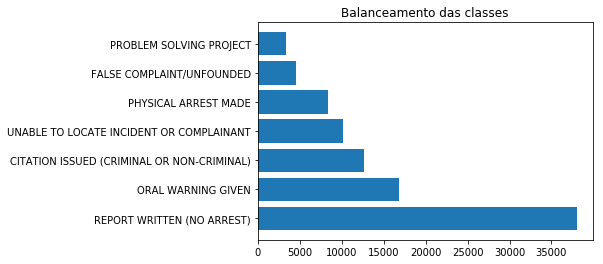

In [5]:
plt.barh(classes.keys(), classes.values)
plt.title('Balanceamento das classes')
plt.show()

### Realizando o EDA

#### Removendo colunas não relacionadas

In [6]:
train_call_data.columns

Index(['Unnamed: 0', 'CAD Event Number', 'Event Clearance Description',
       'Call Type', 'Priority', 'Initial Call Type', 'Final Call Type',
       'Original Time Queued', 'Arrived Time', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

As duas primeiras colunas guardam, respectivamente, um problema na importação (não mencionada na documentação) e o código único do evento. Ambas relacionadas demais a um evento em específico para servirem de _feature_ da generalização.

In [7]:
train_call_data.drop(train_call_data.columns[:2], axis=1, inplace=True)

#### Alterando colunas de texto para informações numéricas e identificando correlações

In [8]:
def get_dict(serie):
    return {name: index for index, name in enumerate(serie.unique())}

In [9]:
def encode_column(serie):
    get_dict_result = get_dict(serie)
    serie = serie.replace(get_dict_result)
    return get_dict_result, serie

In [10]:
target_encode, target_serie = encode_column(train_call_data['Event Clearance Description'])

In [11]:
call_type_encode, call_type_serie = encode_column(train_call_data['Call Type'])

In [12]:
call_type_encode, np.array(call_type_serie).reshape(1,-1)

({'TELEPHONE OTHER, NOT 911': 0,
  'ONVIEW': 1,
  '911': 2,
  'ALARM CALL (NOT POLICE ALARM)': 3,
  'POLICE (VARDA) ALARM': 4,
  'IN PERSON COMPLAINT': 5,
  'HISTORY CALL (RETRO)': 6},
 array([[0, 1, 0, ..., 0, 0, 2]]))

O motivo do por que fazer esta transformação é poder utilizar uma das funcionalidades do _pandas_ que é analisar a correlação entre as _features_. Como nos exemplos abaixo:

In [13]:
pd.DataFrame({'call_type': call_type_serie.values,\
              'target': target_serie.values}).corr()

,call_type,target
call_type,1.000000,0.174016
target,0.174016,1.000000


E assim podemos verificar que existe uma relação de 17% entre o tipo da chamada e o resultado da mesma. Relação forte? Teremos mais conhecimento quando analisarmos a correlação de todas as variáveis.

In [14]:
train_call_data.head(1)

,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Original Time Queued,Arrived Time,Precinct,Sector,Beat
0,CITATION ISSUED (CRIMINAL OR NON-CRIMINAL),"TELEPHONE OTHER, NOT 911",3,TRAFFIC - BLOCKING ROADWAY,TRAFFIC - BLOCKING ROADWAY,06/02/2009 03:43:08 AM,Jun 2 2009 05:47:21:000AM,WEST,QUEEN,Q1


In [15]:
tmp_data = pd.DataFrame()
for x in train_call_data.drop(['Original Time Queued', 'Arrived Time'], axis=1).columns:
    _, replaced = encode_column(train_call_data[x])
    tmp_data[x] = replaced

In [16]:
tmp_data.corr()

,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Precinct,Sector,Beat
Event Clearance Description,1.000000,0.174016,0.069910,0.097139,0.278728,-0.032752,-0.034164,-0.017019
Call Type,0.174016,1.000000,-0.084475,0.012884,0.156335,0.023755,0.005382,0.001365
Priority,0.069910,-0.084475,1.000000,0.234399,-0.025338,-0.031780,-0.018081,-0.014382
Initial Call Type,0.097139,0.012884,0.234399,1.000000,0.268713,0.014020,0.005388,0.006302
Final Call Type,0.278728,0.156335,-0.025338,0.268713,1.000000,0.030101,0.021750,0.014177
Precinct,-0.032752,0.023755,-0.031780,0.014020,0.030101,1.000000,0.690733,0.397231
Sector,-0.034164,0.005382,-0.018081,0.005388,0.021750,0.690733,1.000000,0.483555
Beat,-0.017019,0.001365,-0.014382,0.006302,0.014177,0.397231,0.483555,1.000000


**Uma observação importante** é que retiramos as colunas que envolvem data/hora desta primeira análise porque elas não apresentam um padrão (ou classes). Devemos então focar, para poder analisar estes resultados, tentar extrair generalizações destas colunas como, por sugestão nossa: **o período do dia (manhã, tarde, noite ou madrugada), o dia da semana ou o tempo decorrido entre o momendo da chamada e o atendimento**.

In [17]:
data_corr = tmp_data.corr()['Event Clearance Description']
data_corr

Event Clearance Description    1.000000
Call Type                      0.174016
Priority                       0.069910
Initial Call Type              0.097139
Final Call Type                0.278728
Precinct                      -0.032752
Sector                        -0.034164
Beat                          -0.017019
Name: Event Clearance Description, dtype: float64

Quando esquecemos as correlações das outras variáveis e focamos somente em nossa _target_, encontramos que existe uma relação de **27% entre o tipo final da chamada ('Final Call Type') com a resulação desta ('Event Clearance Description')**. Unindo esta constatação poderíamos unir nossos esforços na análise das variáveis que maior impactam o nosso resultado. 

Mas ficam duas perguntas que precisamos responder quando analisamos as correlações. 

A primeira delas é: _O que representam estes valores negativos?_

In [18]:
data_corr[5:]

Precinct   -0.032752
Sector     -0.034164
Beat       -0.017019
Name: Event Clearance Description, dtype: float64

Correlação negativa representa uma relação inversa não entre as variáveis, mas entre seus valores. O que queremos dizer? Quando a classe da primeira variável cresce (e estamos falando do código único), o identificador da variável resultado tende a cair (também falando do _id_). Em nosso caso, como estamos analisando quais variáveis influenciam mais na nossa _target_, podemos olhar valores absolutos (desconsiderando o valor negativo porque o id não é importante para a gente, mas somente o fato de que alterando uma variável a outra sofrerá modificações). 

In [19]:
data_corr.abs().sort_values()

Beat                           0.017019
Precinct                       0.032752
Sector                         0.034164
Priority                       0.069910
Initial Call Type              0.097139
Call Type                      0.174016
Final Call Type                0.278728
Event Clearance Description    1.000000
Name: Event Clearance Description, dtype: float64

E a segunda é: _Por que a soma não apresenta 100%?_

In [20]:
data_corr.sum()-1

0.5358582846415003

A resposta para esta pergunta é mais simples justamente pela justificativa que o resultado da correlação não é sobre qual variável é mais importante no conjunto, mas como uma variável influencia outra (as análises são independentes). Se quiséssimos calcular uma proporção, poderíamos fazer calculando um valor percentual sobre todas a variáveis envolvidas.

**Note** que o modificador constante -1 acima é para retirar o valor 1 presente na correlação da variável com ela mesma (última linha na apresentação das correlações).

In [21]:
data_corr.abs().sum()-1

0.7037272415891818

In [22]:
pie_data = data_corr.abs().sort_values()[:7]/0.7037272415891818

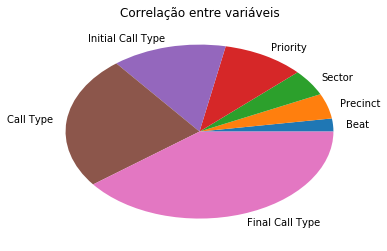

In [23]:
plt.pie(pie_data, labels=pie_data.index)
plt.title("Correlação entre variáveis")
plt.show()

#### Analisando tipo de resolução contra variáveis de tempo

In [24]:
X_time = train_call_data.loc[:,['Original Time Queued', 'Arrived Time']]

In [25]:
X_time['Original Time Queued'] = pd.to_datetime(X_time['Original Time Queued'])

In [26]:
X_time['Arrived Time'] = pd.to_datetime(X_time['Arrived Time'], format='%b  %d %Y %H:%M:%S:%f%p')

In [27]:
X_time['diff_minutes'] = (X_time['Arrived Time']-X_time['Original Time Queued']).astype('timedelta64[m]')

In [28]:
X_time['day_of_week'] = X_time['Original Time Queued'].dt.dayofweek

Para definir o período, primeiro precisamos identificar os intervalos. Optamos por escolher:
* Das 4 as 12, o período 1
* Das 12 as 8, período 2
* Demias, período 3

In [29]:
def get_period_from_hour(hour):
    if hour >= 6 and hour <= 11:
        return 'Matutino'
    else:
        if hour >= 12 and hour <= 17:
            return 'Vespertino'
        else:
            if hour >= 18 and hour <= 23:
                return 'Noturno'
            else:
                return 'Madrugada'

In [30]:
X_time['date_period'] = X_time['Original Time Queued'].dt.hour.map(get_period_from_hour)

In [31]:
X_time['date_period'].isnull().any()

False

E agora listando todas as colunas que nos são relevantes

In [32]:
X_time = X_time.iloc[:,2:]

Uma ves que conseguimos separar as variáveis de tempo, devemos fazer um estudo mais ou menos como foi feito com as outras variáveis. Para isto, devemos inserir a nossa coluna alvo para uma análise do comportamento das variáveis.

In [33]:
X_time['Target']= train_call_data['Event Clearance Description']

In [34]:
X_time.head(10)

,diff_minutes,day_of_week,date_period,Target
0,124.0,1,Madrugada,CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)
1,0.0,1,Madrugada,PROBLEM SOLVING PROJECT
2,28.0,1,Madrugada,UNABLE TO LOCATE INCIDENT OR COMPLAINANT
3,-57547675.0,1,Madrugada,REPORT WRITTEN (NO ARREST)
4,0.0,1,Madrugada,REPORT WRITTEN (NO ARREST)
5,67.0,1,Madrugada,ORAL WARNING GIVEN
6,14.0,1,Madrugada,UNABLE TO LOCATE INCIDENT OR COMPLAINANT
7,-57547691.0,1,Madrugada,UNABLE TO LOCATE INCIDENT OR COMPLAINANT
8,45.0,1,Madrugada,UNABLE TO LOCATE INCIDENT OR COMPLAINANT
9,0.0,1,Madrugada,ORAL WARNING GIVEN


In [35]:
X_time['Target'] = X_time['Target'].replace(target_encode)

In [36]:
X_time.head(10)

,diff_minutes,day_of_week,date_period,Target
0,124.0,1,Madrugada,0
1,0.0,1,Madrugada,1
2,28.0,1,Madrugada,2
3,-57547675.0,1,Madrugada,3
4,0.0,1,Madrugada,3
5,67.0,1,Madrugada,4
6,14.0,1,Madrugada,2
7,-57547691.0,1,Madrugada,2
8,45.0,1,Madrugada,2
9,0.0,1,Madrugada,4


Analisando o tempo de atendimento por tipo de evento.

In [37]:
X_time['diff_minutes'].value_counts()

-720.0         20232
 0.0           14385
 720.0          1891
-716.0          1366
-715.0          1344
-717.0          1298
-714.0          1194
-713.0          1169
-718.0          1116
-712.0          1021
 4.0             940
 3.0             932
-711.0           925
 6.0             904
 5.0             890
-719.0           879
-710.0           846
 2.0             809
 7.0             781
-709.0           762
 8.0             713
-708.0           698
 9.0             656
 1.0             608
-707.0           602
 10.0            597
-706.0           552
 11.0            546
-705.0           515
 12.0            483
               ...  
-57604553.0        1
-57604750.0        1
-57604839.0        1
-57604937.0        1
-57605029.0        1
-57611748.0        1
-57603271.0        1
-57603235.0        1
-57603136.0        1
-57603078.0        1
-57601280.0        1
-57601374.0        1
-57601454.0        1
-57601591.0        1
-57601641.0        1
-57601675.0        1
-57601825.0  

Vemos números exorbiantes. Devemos interpretar como _outliers_ ou como uma característica de determinados eventos?

In [38]:
X_time[X_time.diff_minutes == -57783089.0]

,diff_minutes,day_of_week,date_period,Target
79446,-57783089.0,3,Vespertino,0


In [39]:
train_call_data.iloc[79446]

Event Clearance Description         CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)
Call Type                                             TELEPHONE OTHER, NOT 911
Priority                                                                     3
Initial Call Type                     PARKING VIOLATION (EXCEPT ABANDONED CAR)
Final Call Type                --TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR)
Original Time Queued                                    11/12/2009 03:28:15 PM
Arrived Time                                        Jan  1 1900 12:00:00:000AM
Precinct                                                                  WEST
Sector                                                                   QUEEN
Beat                                                                        Q3
Name: 79446, dtype: object

In [40]:
without_arrived_time = train_call_data[train_call_data['Initial Call Type'] == 'PARKING VIOLATION (EXCEPT ABANDONED CAR)']
without_arrived_time.head(5)

,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Original Time Queued,Arrived Time,Precinct,Sector,Beat
14,CITATION ISSUED (CRIMINAL OR NON-CRIMINAL),ONVIEW,3,PARKING VIOLATION (EXCEPT ABANDONED CAR),PARKING VIOLATION (EXCEPT ABANDONED CAR),06/02/2009 05:15:30 AM,Jun 2 2009 05:15:30:000AM,SOUTH,SAM,S3
24,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,911,3,PARKING VIOLATION (EXCEPT ABANDONED CAR),--TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR),06/02/2009 06:18:00 AM,Jan 1 1900 12:00:00:000AM,WEST,QUEEN,Q1
26,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,"TELEPHONE OTHER, NOT 911",3,PARKING VIOLATION (EXCEPT ABANDONED CAR),--TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR),06/02/2009 06:27:11 AM,Jan 1 1900 12:00:00:000AM,NORTH,BOY,B2
28,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,"TELEPHONE OTHER, NOT 911",3,PARKING VIOLATION (EXCEPT ABANDONED CAR),--TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR),06/02/2009 06:40:20 AM,Jan 1 1900 12:00:00:000AM,NORTH,LINCOLN,L2
31,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,911,3,PARKING VIOLATION (EXCEPT ABANDONED CAR),--TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR),06/02/2009 06:46:13 AM,Jan 1 1900 12:00:00:000AM,WEST,MARY,M1


Quando isto acontece temos algumas possibilidades, como:

a) Desconsiderar estes registros para continuar trabalhando com o intervalo de atendimento ou;<br>
b) Preencher esta coluna com alguma informação. 

Optamos então por desconsiderar esta coluna da análise.

In [41]:
X_time.drop(['diff_minutes'], axis=1, inplace=True)

In [42]:
X_time.head(10)

,day_of_week,date_period,Target
0,1,Madrugada,0
1,1,Madrugada,1
2,1,Madrugada,2
3,1,Madrugada,3
4,1,Madrugada,3
5,1,Madrugada,4
6,1,Madrugada,2
7,1,Madrugada,2
8,1,Madrugada,2
9,1,Madrugada,4


Entendendo agora a quantidade de registros por período

In [43]:
periods = X_time['date_period'].value_counts()
periods

Vespertino    30260
Noturno       27205
Matutino      20723
Madrugada     15714
Name: date_period, dtype: int64

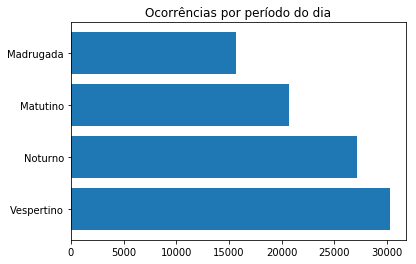

In [44]:
plt.barh(periods.keys(), periods.values, tick_label=periods.keys())
plt.title('Ocorrências por período do dia')
plt.show()

E a quantidade por dia da semana

In [45]:
days_of_week = X_time['day_of_week'].value_counts()
days_of_week

4    14173
1    13997
2    13928
3    13679
0    13312
5    13040
6    11773
Name: day_of_week, dtype: int64

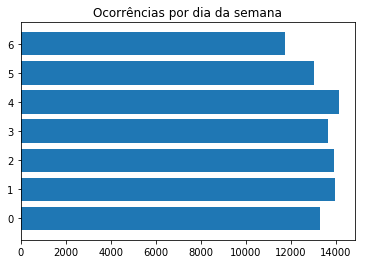

In [46]:
plt.barh(days_of_week.keys(), days_of_week.values, tick_label=days_of_week.keys())
plt.title('Ocorrências por dia da semana')
plt.show()

Bom, pelo menos serviu para tirar a nossa curiosidade. :)

### Preparando os dados para o modelo

<strong>Processo de feature engineering<strong> 

O processo de "_feature engineering_" é a etapa onde selecionamos colunas que teriam seu maior impacto na melhoria da nossa análise, essa seleção faz com que extraímos o potencial máximo das _features_ de um _dataset_, aumentando a flexibilidade, simplicidade e acurácia dos modelos. Escolhemos sempre as _features_ que estão mais correlacionada com nosso alvo _target_.

In [47]:
train_call_data.head(1)

,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Original Time Queued,Arrived Time,Precinct,Sector,Beat
0,CITATION ISSUED (CRIMINAL OR NON-CRIMINAL),"TELEPHONE OTHER, NOT 911",3,TRAFFIC - BLOCKING ROADWAY,TRAFFIC - BLOCKING ROADWAY,06/02/2009 03:43:08 AM,Jun 2 2009 05:47:21:000AM,WEST,QUEEN,Q1


Separando a nossa coluna de aprendizado supervisionado.

In [48]:
y = train_call_data.iloc[:,0].values

In [49]:
import collections

In [50]:
collections.Counter(y)

Counter({'CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)': 12673,
         'PROBLEM SOLVING PROJECT': 3303,
         'UNABLE TO LOCATE INCIDENT OR COMPLAINANT': 10150,
         'REPORT WRITTEN (NO ARREST)': 38008,
         'ORAL WARNING GIVEN': 16837,
         'FALSE COMPLAINT/UNFOUNDED': 4527,
         'PHYSICAL ARREST MADE': 8404})

E, apesar da não necessidade, resolvemos por igualar as classes de saída a fim de usar a acurácia como medidor de qualidade de nossos algorítmos.

In [51]:
i_class0 = np.where(y == 'CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)')[0]
i_class1 = np.where(y == 'PROBLEM SOLVING PROJECT')[0]
i_class2 = np.where(y == 'UNABLE TO LOCATE INCIDENT OR COMPLAINANT')[0]
i_class3 = np.where(y == 'REPORT WRITTEN (NO ARREST)')[0]
i_class4 = np.where(y == 'ORAL WARNING GIVEN')[0]
i_class5 = np.where(y == 'FALSE COMPLAINT/UNFOUNDED')[0]
i_class6 = np.where(y == 'PHYSICAL ARREST MADE')[0]

In [52]:
n_class0 = len(i_class0)
n_class1 = len(i_class1)
n_class2 = len(i_class2)
n_class3 = len(i_class3)
n_class4 = len(i_class4)
n_class5 = len(i_class5)
n_class6 = len(i_class6)

In [53]:
min(n_class0, n_class1, n_class2, n_class3, n_class4, n_class5, n_class6)

3303

In [54]:
i_class0_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)
i_class2_downsampled = np.random.choice(i_class2, size=n_class1, replace=False)
i_class3_downsampled = np.random.choice(i_class3, size=n_class1, replace=False)
i_class4_downsampled = np.random.choice(i_class4, size=n_class1, replace=False)
i_class5_downsampled = np.random.choice(i_class5, size=n_class1, replace=False)
i_class6_downsampled = np.random.choice(i_class6, size=n_class1, replace=False)

In [55]:
y_downsampled = np.hstack((y[i_class0_downsampled],\
           y[i_class1],\
           y[i_class2_downsampled],\
           y[i_class3_downsampled],\
           y[i_class4_downsampled],\
           y[i_class5_downsampled],\
           y[i_class6_downsampled]))

In [56]:
collections.Counter(y_downsampled)

Counter({'CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)': 3303,
         'PROBLEM SOLVING PROJECT': 3303,
         'UNABLE TO LOCATE INCIDENT OR COMPLAINANT': 3303,
         'REPORT WRITTEN (NO ARREST)': 3303,
         'ORAL WARNING GIVEN': 3303,
         'FALSE COMPLAINT/UNFOUNDED': 3303,
         'PHYSICAL ARREST MADE': 3303})

Removendo colunas de datas (vimos que não vale a pena analisá-las aqui)

In [57]:
train_call_data.drop(['Original Time Queued', 'Arrived Time'], axis=1, inplace=True)

Verificando as colunas correlacionadas

In [58]:
X_dataframe = train_call_data.iloc[:,1:]

In [59]:
X_dataframe.head(1)

,Call Type,Priority,Initial Call Type,Final Call Type,Precinct,Sector,Beat
0,"TELEPHONE OTHER, NOT 911",3,TRAFFIC - BLOCKING ROADWAY,TRAFFIC - BLOCKING ROADWAY,WEST,QUEEN,Q1


Adicionando em nossa relação as duas variáveis temporais encontradas nos passos anteriores

In [60]:
X_dateframe = X_dataframe.join(X_time[['day_of_week','date_period']])

In [61]:
X_dateframe.columns

Index(['Call Type', 'Priority', 'Initial Call Type', 'Final Call Type',
       'Precinct', 'Sector', 'Beat', 'day_of_week', 'date_period'],
      dtype='object')

Fazendo o downsampled

In [62]:
X_samples = np.hstack((i_class0_downsampled, 
           i_class1,  
           i_class2_downsampled, 
           i_class3_downsampled, 
           i_class4_downsampled, 
           i_class5_downsampled, 
           i_class6_downsampled))

In [63]:
X_dataframe = X_dataframe.iloc[X_samples]

In [64]:
y_downsampled.shape, X_dataframe.shape

((23121,), (23121, 7))

Transformando as variáveis de classe com o processo de _one-hot_

In [65]:
for column_name in X_dataframe.columns:
    X_dataframe = X_dataframe.join(pd.get_dummies(X_dataframe[column_name], prefix=column_name))
    X_dataframe.drop([column_name], axis=1, inplace=True)

In [66]:
X_dataframe.columns

Index(['Call Type_911', 'Call Type_ALARM CALL (NOT POLICE ALARM)',
       'Call Type_HISTORY CALL (RETRO)', 'Call Type_ONVIEW',
       'Call Type_POLICE (VARDA) ALARM', 'Call Type_TELEPHONE OTHER, NOT 911',
       'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4',
       ...
       'Beat_SWT', 'Beat_U1', 'Beat_U2', 'Beat_U3', 'Beat_US', 'Beat_W',
       'Beat_W1', 'Beat_W2', 'Beat_W3', 'Beat_WS'],
      dtype='object', length=557)

In [67]:
X_dataframe.head(3)

,Call Type_911,Call Type_ALARM CALL (NOT POLICE ALARM),Call Type_HISTORY CALL (RETRO),Call Type_ONVIEW,Call Type_POLICE (VARDA) ALARM,"Call Type_TELEPHONE OTHER, NOT 911",Priority_1,Priority_2,Priority_3,Priority_4,...,Beat_SWT,Beat_U1,Beat_U2,Beat_U3,Beat_US,Beat_W,Beat_W1,Beat_W2,Beat_W3,Beat_WS
68429,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
23495,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52121,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [68]:
X_dataframe.shape

(23121, 557)

### Escolhando e treinando os modelos

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_dataframe.values, y_downsampled, test_size=0.3, random_state=100)

_Os modelos selecionados foram decisivos pelo seu alto valor de acurácia e seu melhor resultado do score em relação a nossa variável alvo e pela característica dos dados. E também por serem muito populares com alto índice de retorno satisfatório_ :)

#### Primeiro modelo escolhido - RandomForest (classificação supervisionada)

O _Random Forest_ cria combinações de "árvores de decisão" aleatórios afim de manter uma maior acurácia para o modelo, suas vantagens além de poder ser utilizado tanto para modelos de classificação quanto para regressão, seu algoritmo é flexível e fácil o que proprociona em muitas casos um bom resultado. Outra caracterista do _Random Forest_ é que ele calcula a importância relativa de cada _feature_, o que auxilia na redução de impureza da floresta. 
A desvantagem do algoritmo está no grande aumento de árvores (mais acurácia requer mais árvores), isto pode acarretar em um algoritmo lento e ineficiente na vida real, outro fator de desvantagem é no controle do _overfitting_, mesmo que não possa ocorrer tão facilmente.

In [71]:
RandomForestClassifier(random_state=100).fit(X_train, y_train).score(X_test, y_test)

0.7323050309932247

In [72]:
random_params = {
    "random_state": [100],
    'n_jobs': [-1],
    'n_estimators': [10,20,30],
    'criterion': ['gini','entropy']
}
random = GridSearchCV(RandomForestClassifier(), param_grid=random_params, cv=3).fit(X_train, y_train)
print (random.best_estimator_, random.score(X_test, y_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=False) 0.7452789390226323


#### Segundo modelo escolhido - Regressão Linear (supervisionada também)

A _Regressão Linear_ quantifica a relação entre uma ou mais variáveis independentes _features_ e uma variável de resultado dependente _target_, seu modelo pode ser utilizado para prever condições futuras. Sua vantagem está na simplicidade do algoritmo onde inicialmente só precisa de apenas 2 parâmetros, já mencionado anteriormente, e depois se resume em encontrar a posição e inclinação da reta o que causa uma boa interpretabilidade visual. A desvantagem está ligada a sua vantagem onde o modelo exige especificação explícita dos _hyperparameters_ para pode encontrar a inclinação e posição mais adequada da reta.

In [73]:
LogisticRegression(random_state=100).fit(X_train, y_train).score(X_test, y_test)

0.7669021190716448

In [74]:
lr_params = {
    'random_state': [100],
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'C': [1,2,3,5,8]
}
lr = GridSearchCV(LogisticRegression(), param_grid=lr_params, cv=3).fit(X_train, y_train)
print (lr.best_estimator_, lr.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 0.7669021190716448


In [75]:
lr_params = {
    'random_state': [100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'C': [1,2],
    'n_jobs': [-1]
}
lr = GridSearchCV(LogisticRegression(), param_grid=lr_params, cv=3).fit(X_train, y_train)
print (lr.best_estimator_, lr.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=100, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False) 0.767190428138965


**Note** A única situação pela qual necessitamos repetir os testes do GridSearch foi devido a penalidade (l1 ou l2). Cada uma delas possui algorítmos que melhor lhe convêm.

### Grid Search

O recurso _Grid Search_ consiste em analisar múltiplas combinações de _hyperparameters_, que para cada combinação, é feita uma análise da performance do algoritmo. Visto que esta não é uma tarefa simples, pois dependendo do algoritmo selecionado o mesmo pode conter vários parametros disponíveis. 
E para você desenvolvedor não se basear em chutes ou "achismo" o gridsearch irá testar cada valor exaustivamente para você e encontrar uma melhor acurácia para seu modelo.


### Cross Validation

O _Cross Validation_ significa "validação cruzada" seu método se resume em capturar um conjunto de dados do _dataset_ realizar a validaçao propriamente dita nos dados, e em seguida, capturar novos conjuntos de dados aleatório e iniciar o processo de validação novamente, e o ciclo se reiniciar até percorrer todo o conjunto de dados. Esse recurso visa estimar o quão preciso é a qualidade do modelo em diversos cenários (diferentes conjuntos de dados).

**Em nossos modelos, optamos por fazer o _Cross Validation_ através do parâmetro CV do _GridSearchCV_**

### Acurácia

Para medir a qualidade de nossos modelos (e poder compará-los), usamos a acurácia.

A acuácia mede a aproximidade do valor predito com o valor real, comparando a quantidade de acertos e a quantidade de erros. É sem dúvida a maneira mais fácil e intuitiva de medir a qualidade de um modelo, mas precisa de alguns cuidados, como o balanceamento dos dados de entrada. :) Fizemos isso por meio de uma técnica chamada _Downsampling_.

Comparando nossos modelos, sugeriríamos para resolver o atual problema o uso do:

_LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=100, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False) _

Que possui uma taxa de acerto de **0.7777137090961511**

In [103]:
pd.DataFrame(random.estimator.feature_importances_, X_dataframe.columns.values).sort_values(0, ascending=False)

,0
"Initial Call Type_PREMISE CHECK, OFFICER INITIATED ONVIEW ONLY",0.077196
Final Call Type_--TRAFFIC - MOVING VIOLATION,0.039351
Call Type_ONVIEW,0.036371
"Initial Call Type_ALARM - COMM, SILENT/AUD BURG (INCL BANKS)",0.033962
"Initial Call Type_ALARM - RESIDENTIAL - BURGLARY, SILENT/AUDIBLE",0.030600
Priority_7,0.028182
Final Call Type_--PREMISE CHECKS - CRIME PREVENTION,0.026710
Initial Call Type_PARKING VIOLATION (EXCEPT ABANDONED CAR),0.024431
"Call Type_TELEPHONE OTHER, NOT 911",0.021123
"Final Call Type_--ALARM-COMM (INC BANK, ATM, SCHOOLS, BSN)",0.020248
